# Loading Libraries

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import os
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from keras import regularizers
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

main_accent_colour = "#b366ff"
dim_colour="darkgrey"
main_palette = ["#FBE5C0", "#DD9A30", "#F88379", "#FF6FC2", "purple", "#D086F6", "#B0D2C2", "#4C5D70", "#6FA2CE", "#382D24", "#3ACF3A", "#7D7D00"]

# Analyzing

In [6]:
train_dir = 'fer2013 cleaned/train/'
test_dir = 'fer2013 cleaned/test/'

row = 48
col = 48
classes = len(os.listdir('fer2013 cleaned/train/'))

In [7]:
print("Train Set :")

train_count = []
for folder in os.listdir(train_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(train_dir+folder)), "image")
    train_count.append(len(os.listdir(train_dir+folder)))
    
print()

test_count = []
print("Test Set :")
for folder in os.listdir(test_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(test_dir+folder)), "images")
    test_count.append(len(os.listdir(test_dir+folder)))

Train Set :
Anger folder contains		 3315 image
Disgust folder contains		 436 image
Fear folder contains		 3346 image
Happy folder contains		 3334 image
Neutral folder contains		 3376 image
Sad folder contains		 3192 image
Surprise folder contains		 3321 image

Test Set :
Anger folder contains		 828 images
Disgust folder contains		 111 images
Fear folder contains		 836 images
Happy folder contains		 833 images
Neutral folder contains		 806 images
Sad folder contains		 798 images
Surprise folder contains		 830 images


# Preprocessing

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 20320 images belonging to 7 classes.
Found 5042 images belonging to 7 classes.


In [9]:
training_set.class_indices

{'Anger': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

# Model

In [10]:
def get_model(input_size, classes=7):
    
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
    #              loss='categorical_crossentropy', 
    #              metrics=['accuracy'])
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1e-6,
    decay_rate=1.0)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [11]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

In [12]:
plot_model(fernet, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Checkpoint

In [13]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [14]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                  validation_data=test_set,
                  epochs=100,
                  callbacks=callbacks,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)

Epoch 1/100
317/317 [==============================] - ETA: 0s - loss: 4.4283 - accuracy: 0.2842
Epoch 1: val_loss improved from inf to 8.91029, saving model to ferNet.h5


c:\Users\M4L_J\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


317/317 [==============================] - 1318s 4s/step - loss: 4.4283 - accuracy: 0.2842 - val_loss: 8.9103 - val_accuracy: 0.1729 - lr: 1.0000e-04
Epoch 2/100
317/317 [==============================] - ETA: 0s - loss: 3.6632 - accuracy: 0.3579
Epoch 2: val_loss improved from 8.91029 to 3.62115, saving model to ferNet.h5
317/317 [==============================] - 854s 3s/step - loss: 3.6632 - accuracy: 0.3579 - val_loss: 3.6212 - val_accuracy: 0.4289 - lr: 1.0000e-04
Epoch 3/100
317/317 [==============================] - ETA: 0s - loss: 3.2358 - accuracy: 0.4041 
Epoch 3: val_loss improved from 3.62115 to 2.96210, saving model to ferNet.h5
317/317 [==============================] - 3665s 12s/step - loss: 3.2358 - accuracy: 0.4041 - val_loss: 2.9621 - val_accuracy: 0.4860 - lr: 1.0000e-04
Epoch 4/100
317/317 [==============================] - ETA: 0s - loss: 2.8499 - accuracy: 0.4549
Epoch 4: val_loss improved from 2.96210 to 2.51450, saving model to ferNet.h5
317/317 [===============

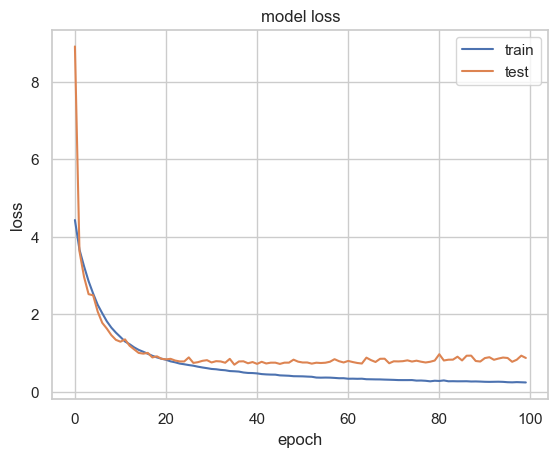

In [26]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

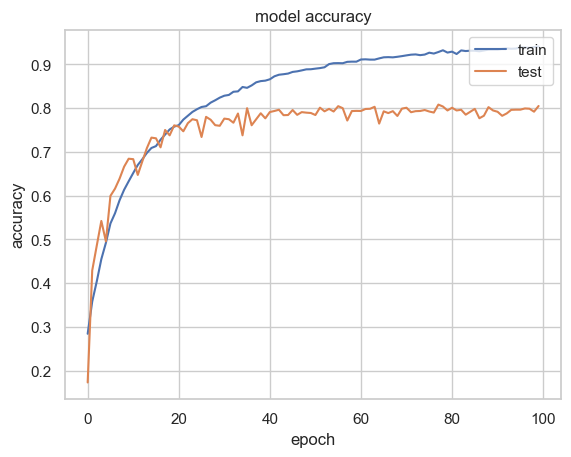

In [16]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [17]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

79/79 [==============================] - 41s 518ms/step - loss: 0.8659 - accuracy: 0.8052
final train accuracy = 97.87 , validation accuracy = 80.52


In [18]:
# save model
fernet.save('fModel.h5')
print('Model Saved!')

Model Saved!


In [19]:
model_json = fernet.to_json()
with open("Updatedmodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
fernet.save_weights("Updatedmodel.h5")
print("Saved model to disk")

Saved model to disk


# Result

318/318 [==============================] - 270s 844ms/step
Confusion Matrix
[[565  77 543 492 531 559 548]
 [ 80  16  68  58  61  87  66]
 [537  58 564 551 551 539 546]
 [573  67 570 539 549 501 535]
 [535  64 556 598 562 521 540]
 [529  59 513 555 559 475 502]
 [523  60 509 549 570 537 573]]
Classification Report
              precision    recall  f1-score   support

       Anger       0.17      0.17      0.17      3315
     Disgust       0.04      0.04      0.04       436
        Fear       0.17      0.17      0.17      3346
       Happy       0.16      0.16      0.16      3334
     Neutral       0.17      0.17      0.17      3376
         Sad       0.15      0.15      0.15      3192
    Surprise       0.17      0.17      0.17      3321

    accuracy                           0.16     20320
   macro avg       0.15      0.15      0.15     20320
weighted avg       0.16      0.16      0.16     20320



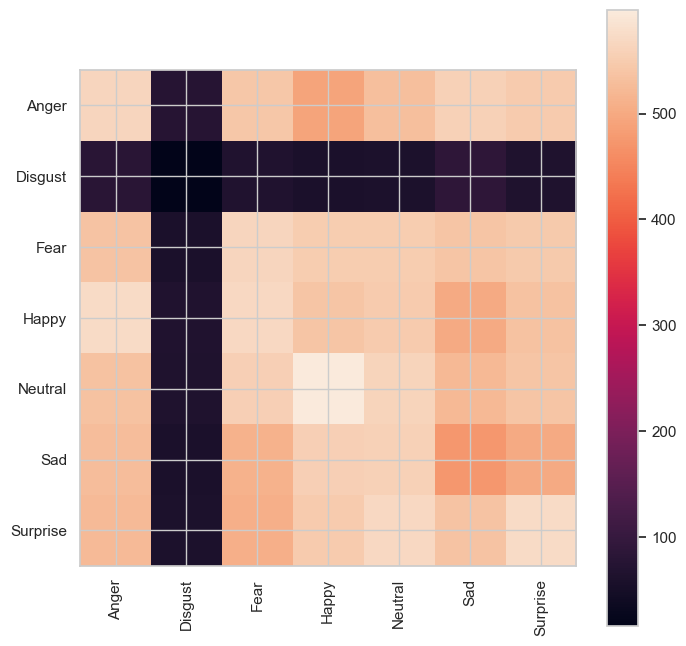

In [20]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

79/79 [==============================] - 47s 596ms/step
Confusion Matrix
[[145  13 122 136 143 137 132]
 [ 19   1  20  14  17  22  18]
 [131  11 126 150 153 131 134]
 [140  12 141 131 149 128 132]
 [138  12 129 137 157 103 130]
 [145  14 124 117 152 126 120]
 [136  14 150 123 158 126 123]]
Classification Report
              precision    recall  f1-score   support

       Anger       0.17      0.18      0.17       828
     Disgust       0.01      0.01      0.01       111
        Fear       0.16      0.15      0.15       836
       Happy       0.16      0.16      0.16       833
     Neutral       0.17      0.19      0.18       806
         Sad       0.16      0.16      0.16       798
    Surprise       0.16      0.15      0.15       830

    accuracy                           0.16      5042
   macro avg       0.14      0.14      0.14      5042
weighted avg       0.16      0.16      0.16      5042



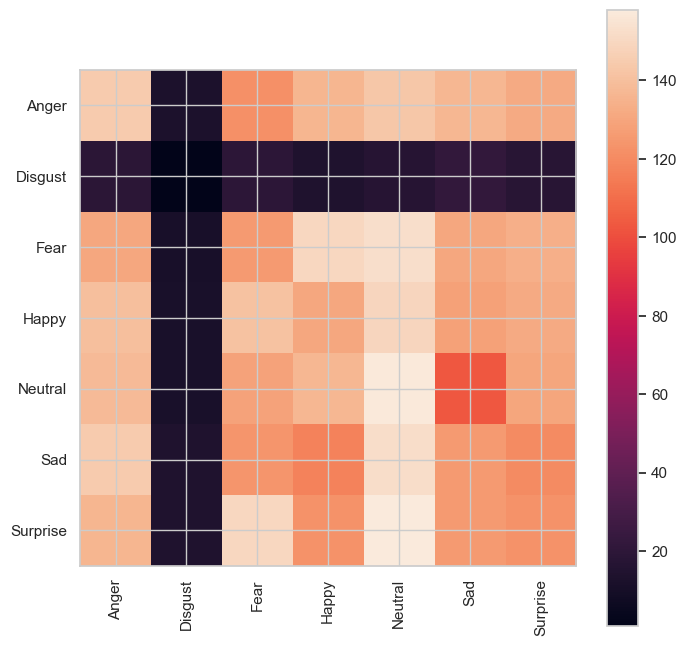

In [21]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

# Recommending Music

In [22]:
mood_music = pd.read_csv("spotify-music-data-to-identify-the-moods/data_moods.csv")
mood_music = mood_music[['name','artist','mood']]
mood_music.head()

,name,artist,mood
0,1999,Prince,Happy
1,23,Blonde Redhead,Sad
2,9 Crimes,Damien Rice,Sad
3,99 Luftballons,Nena,Happy
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic


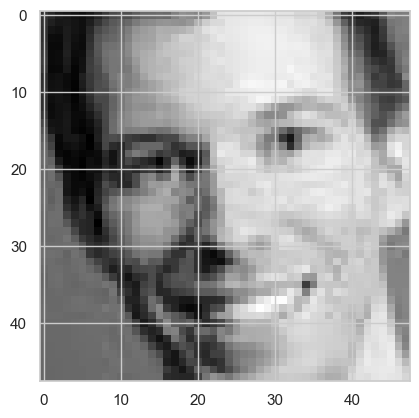

In [23]:
image = cv2.imread('fer2013 cleaned/test/happy/2_27828_Training.jpg',cv2.IMREAD_GRAYSCALE)

plt.imshow(image,cmap='gray')
plt.show()

In [24]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=fernet.predict(img) 
result=np.argmax(predict_x,axis=1)
result[0]

1/1 [==============================] - 0s 444ms/step


3

In [25]:
if(result[0]==0 or result[0]==1 or result[0]==2 ):
    #for angery,disgust,fear
    filter1=mood_music['mood']=='Calm'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==3 or result[0]==4):
    #for happy, neutral
    filter1=mood_music['mood']=='Happy'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==5):
       #for Sad
    filter1=mood_music['mood']=='Sad'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==6):
     #for surprise
    filter1=mood_music['mood']=='Energetic'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)

,index,name,artist,mood
0,3,99 Luftballons,Nena,Happy
1,512,Story Of A Violin,Sandro Silva,Happy
2,617,War,Kensington,Happy
3,369,Never Letting Go,Audien,Happy
4,35,Are You Gonna Be My Girl,Jet,Happy
